In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [32]:
from tqdm import tqdm_notebook

from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import r2_score
from sklearn.externals import joblib

from sorder.models.linear_regression import Corpus
from sorder.metrics import Metrics
from sorder.utils import sort_by_key

In [125]:
import numpy as np

import attr
import warnings

from cached_property import cached_property
from collections import defaultdict, Counter, OrderedDict

from scipy import stats


warnings.simplefilter("ignore")


def sort_by_key(d, desc=False):
    """Sort dictionary by key.
    """
    items = sorted(d.items(), key=lambda x: x[0], reverse=desc)
    return OrderedDict(items)


@attr.s
class Metrics:

    gold_pred = attr.ib()

    @cached_property
    def len_counts(self):
        """Sentence count -> count.
        """
        lengths = map(len, [g for g, _ in self.gold_pred])
        return Counter(list(lengths))

    @cached_property
    def kts_by_len(self):
        """Kendall's tau by sentence count.
        """
        kts = defaultdict(list)

        for gold, pred in self.gold_pred:
            kt, _ = stats.kendalltau(gold, pred)
            kts[len(gold)].append(kt)

        return kts

    def avg_kt_by_len(self, max_len=10):
        """Average KT for each sentence count.
        """
        return sort_by_key({
            slen: sum(kts) / len(kts)
            for slen, kts in self.kts_by_len.items()
            if slen <= max_len
        })

    @cached_property
    def all_kts(self):
        """Set of all KT scores.
        """
        return [kt for kts in self.kts_by_len.values() for kt in kts]

    def overall_kt(self):
        """Overall average KT.
        """
        return sum(self.all_kts) / len(self.all_kts)

    def perfect_order_pct_by_len(self, max_len=10):
        """Percent perfect order by sentence count.
        """
        perfect = Counter()

        for gold, pred in self.gold_pred:
            if gold == pred:
                perfect[len(gold)] += 1

        return sort_by_key({
            slen: perfect.get(slen, 0) / self.len_counts[slen]
            for slen in self.len_counts
            if slen <= max_len
        })

    def overall_perfect_order_pct(self):
        """Percent perfect order overall.
        """
        perfect = sum([1 for g, p in self.gold_pred if g==p])
        return perfect / len(self.gold_pred)

In [3]:
dv = joblib.load('dv.bin')

In [4]:
vocab = joblib.load('vocab.bin')

In [5]:
fit = joblib.load('fit.bin')

In [6]:
test = Corpus('/Users/dclure/Projects/sent-order/data/test.json')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [7]:
test_x, test_y = zip(*test.xy(vocab))

HBox(children=(IntProgress(value=0, max=110615), HTML(value='')))

In [8]:
test_x = dv.transform(test_x)

In [22]:
def predict(corpus, dv, vocab, fit):
    """Predict order for all abstracts in a corpus.
    """
    gold_pred = []
    
    for ab in tqdm_notebook(corpus.abstracts):

        x, _ = zip(*ab.xy(vocab))
        x = dv.transform(x)

        pred = list(fit.predict(x).argsort().argsort())
        gold = list(range(len(pred)))

        gold_pred.append((gold, pred))
        
    return gold_pred

In [23]:
test_gp = predict(test, dv, vocab, fit)

HBox(children=(IntProgress(value=0, max=110615), HTML(value='')))

In [126]:
test_metrics = Metrics(test_gp)

# Perfect order

In [127]:
test_metrics.overall_perfect_order_pct()

0.23986801066763097

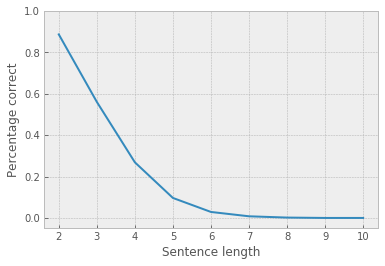

In [139]:
xy = test_metrics.perfect_order_pct_by_len()

x, y = zip(*xy.items())

plt.ylim(-0.05, 1)
plt.xticks(x)
plt.xlabel('Sentence length')
plt.ylabel('Percentage correct')
plt.plot(x, y)

# Kendall's tau

In [129]:
test_metrics.overall_kt()

0.5497242452182497

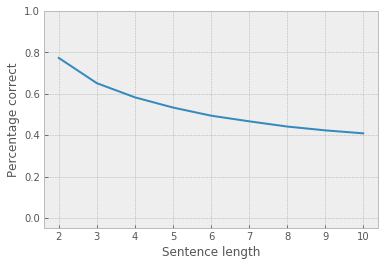

In [142]:
xy = test_metrics.avg_kt_by_len()

x, y = zip(*xy.items())

plt.ylim(-0.05, 1)
plt.xticks(x)
plt.xlabel('Sentence length')
plt.ylabel('Percentage correct')
plt.plot(x, y)